<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-Tensorflow/blob/master/ch4/ch4_nb2_reuse_models_from_keras_apps.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 4: Influential Classification Tools</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">Notebook 2:</small><br/>Reusing Models from Keras Applications</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In the previous [notebook](./ch4_nb1_implement_resnet_from_scratch.ipynb), we learned how to reimplement a state-of-the-art CNN such as ResNet. However, as discussed in Chapter 4, both TensorFlow and Keras provides well-curated implementations for several standard architectures.
    <br/><br/>
    Therefore, we will demonstrate in this notebook how to use models from <em><strong>Keras Applications</strong></em> (<a href="https://keras.io/applications" title="Keras Documentation">https://keras.io/applications</a>), choosing once again <em>ResNet-50</em> applied to classifying <em>CIFAR-100</em>.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [2]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import math

# Choosing which GPU this notebook can access
# (useful when running multiple experiments in parallel, on different GPUs):
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 

# Some hyper-parameters:
input_shape = [224, 224, 3] # We will resize the input images to this shape
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 300           # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

## Preparing the Data

To directly compare with the results from the [previous notebook](./ch4_nb1_implement_resnet_from_scratch.ipynb), we will again apply our model to the classification of the benchmark dataset_CIFAR-100_, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton[$^1$](#ref).

We will reuse the input pipelines defined in the previous notebook:

In [ ]:
# !pip install tensorflow-datasets # Uncomment to install the module

In [3]:
import cifar_utils

cifar_info = cifar_utils.get_info()
print(cifar_info)

# Number of classes:
num_classes = cifar_info.features['label'].num_classes

# Number of images:
num_train_imgs = cifar_info.splits['train'].num_examples
num_val_imgs = cifar_info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

tfds.core.DatasetInfo(
    name='cifar100',
    version=1.3.1,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100)
    },
    total_num_examples=60000,
    splits={
        'test': <tfds.core.SplitInfo num_examples=10000>,
        'train': <tfds.core.SplitInfo num_examples=50000>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @TECHREPORT{Krizhevsky09learning

In [4]:
train_cifar_dataset = cifar_utils.get_dataset(
    phase='train', batch_size=batch_size, num_epochs=num_epochs, shuffle=True,
    input_shape=input_shape, seed=random_seed)

val_cifar_dataset = cifar_utils.get_dataset(
    phase='test', batch_size=batch_size, num_epochs=1, shuffle=False,
    input_shape=input_shape, seed=random_seed)

## Reusing ResNet-50 from Keras Apps

### Instantiating the Model

As explained in the chapter, models provided by Keras through its `applications` package have a standard signature. For this notebook, we will instantiate a *ResNet-50* model[$^2$](#ref), with randomly-initialized parameters (we could directly reuse the  weights pre-trained on ImageNet which are provided by Keras, but the point here is to demonstrate how to retrain such a model from scratch).

Note that like in the previous notebook, we resize the _CIFAR_ images to $224\times224$ (to have a pipeline similar to the one used by the *ResNet* authors in their experiments):

In [5]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights=None, 
    input_shape=input_shape, classes=num_classes)
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

Comparing to the _ResNet-50_ we implemented ourselves previously, we can notice the architectures are slightly different. Our curious readers can try spotting the differences, c.f. the Keras [sources](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) (which are well commented).

### Training the Network

Once instantiated, our model from Keras Applications is like any ohter Keras model. Exactly as we did previously, we will train it on _CIFAR_:

In [6]:
import collections
import functools
from keras_custom_callbacks import SimpleLogCallback

# Defining a custom metrics (top-5 accuracy), from a more generic one provided by Keras:
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')

metrics_to_print = collections.OrderedDict([("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"), 
                                            ("v-top5-acc", "val_top5_acc")])

# Defining optimizer and callbacks for the training:
optimizer = tf.keras.optimizers.Adam()

model_dir = './models/resnet_keras_app'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_acc',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model, e.g., every 5 epochs:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1)
]

# Finally, compiling and training:
resnet50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                 metrics=[accuracy_metric, top5_accuracy_metric])

history = resnet50.fit(train_cifar_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                       validation_data=val_cifar_dataset, validation_steps=val_steps_per_epoch,
                       verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/300: loss = 4.191; v-loss = 3.947; acc = 0.071; v-acc = 0.099; top5-acc = 0.240; v-top5-acc = 0.319
Epoch  1/300: loss = 3.624; v-loss = 3.709; acc = 0.146; v-acc = 0.142; top5-acc = 0.389; v-top5-acc = 0.386
Epoch  2/300: loss = 3.175; v-loss = 3.120; acc = 0.222; v-acc = 0.243; top5-acc = 0.512; v-top5-acc = 0.533
Epoch  3/300: loss = 2.727; v-loss = 2.646; acc = 0.307; v-acc = 0.333; top5-acc = 0.622; v-top5-acc = 0.643
Epoch  4/300: loss = 2.446; v-loss = 4.437; acc = 0.366; v-acc = 0.280; top5-acc = 0.685; v-top5-acc = 0.558
Epoch  5/300: loss = 2.206; v-loss = 2.454; acc = 0.420; v-acc = 0.414; top5-acc = 0.731; v-top5-acc = 0.724
Epoch  6/300: loss = 1.985; v-loss = 2.148; acc = 0.468; v-acc = 0.447; top5-acc = 0.773; v-top5-acc = 0.738
Epoch  7/300: loss = 1.818; v-loss = 2.288; acc = 0.504; v-acc = 0.464; top5-acc = 0.807; v-top5-acc = 0.761
Epoch  8/300: loss = 1.647; v-loss = 3.794; acc = 0.547; v-acc = 0.529; top5-acc = 0.836; v-top5-acc = 0.812
Ep

Like in the previous notebook, the training can also be followed in Tensorboard (launched with `tensorboard --logdir ./models`, and accessed at [localhost:6006](localhost:6006)). Since the metrics have the same name as for the model we built from scratch, Tensorboard is displaying them together, making it easy to visually compare the two models:

![Tensorboard screenshot - joint results](./notebook_images/resnet_keras_app_tensorboard_training.png)

As we did last time, we can also use the `history` object returned by `model.fit()` to draw some training and validation trends:

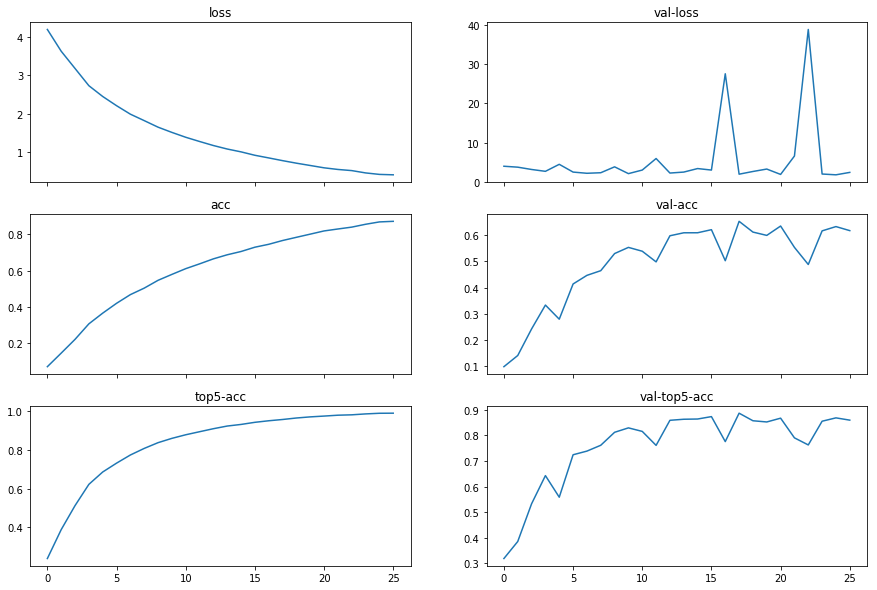

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(15,10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['acc'])
ax[1, 1].plot(history.history['val_acc'])
ax[2, 0].plot(history.history['top5_acc'])
ax[2, 1].plot(history.history['val_top5_acc'])


In [11]:
best_val_acc = max(history.history['val_acc']) * 100
best_val_top5 = max(history.history['val_top5_acc']) * 100

print('Best val acc:  {:2.2f}%'.format(best_val_acc))
print('Best val top5: {:2.2f}%'.format(best_val_top5))

Best val acc:  65.20%
Best val top5: 88.63%


### Predicting with the Network

Once again reusing the functions implemented in the pevious notebook, as well as the test pictures presented there, let us have a look at how our new model performs on completely different images:

Test Images: (16, 224, 224, 3)


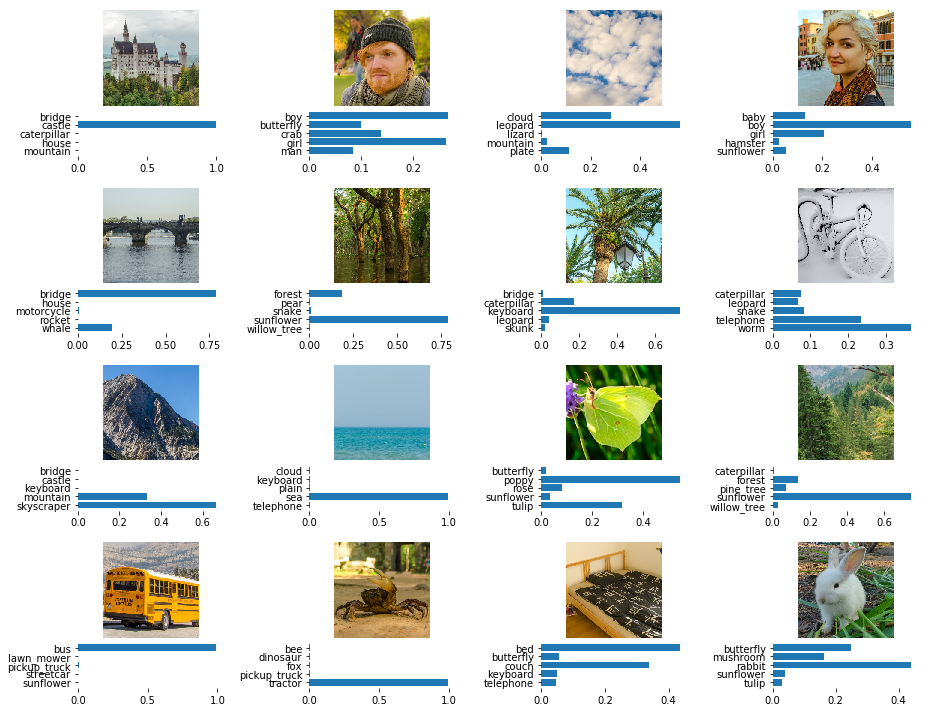

In [12]:
import glob
import numpy as np
from classification_utils import load_image, process_predictions, display_predictions

test_filenames = glob.glob(os.path.join('res', '*'))
test_images = np.asarray([load_image(file, size=input_shape[:2]) for file in test_filenames])
print('Test Images: {}'.format(test_images.shape))

image_batch = test_images[:16]

# Our model was trained on CIFAR images, which originally are 32x32px. We scaled them up
# to 224x224px to train our model on, but this means the resulting images had important
# artifacts/low quality.
# To test on images of the same quality, we first resize them to 32x32px, then to the 
#expected input size (i.e., 224x224px):
cifar_original_image_size = cifar_info.features['image'].shape[:2]
image_batch_low_quality = tf.image.resize(image_batch, cifar_original_image_size)
image_batch_low_quality = tf.image.resize(image_batch_low_quality, input_shape[:2])
    

predictions = resnet50.predict_on_batch(image_batch_low_quality)

class_readable_labels = cifar_info.features["label"].names
top5_labels, top5_probabilities = process_predictions(predictions, class_readable_labels)
    
display_predictions(image_batch, top5_labels, top5_probabilities)

## Conclusion

Good news for our previous implementation: the performance of the curated Keras version of ResNet-50 is about the same! A ~88% top-5 accuracy is a decent score, given the high number of classes / low number of training images (though state-of-the-art methods reach much higher scores). In Chapter 4, we covered several methods which could be used to improve the performance at minimal costs, e.g.:

 - **Prediction averaging** over several images derived from the original input (c.f. _scale jittering_);
 - **Model averaging** by training other models (e.g., Inception, ResNet-18, etc.) and comparing/averaging their predictions for each input;
 - **Transfer learning**;
 - etc.
 
While we leave it to our readers to experiment with some of these methods by themselves, we will dedicate the next notebooks to transfer learning.

<a id="ref"></a>
#### References

1. Krizhevsky, Alex, Hinton, Geoffrey. "*Learning multiple layers of features from tiny images*" (2009), Citeseer.
2. He, K., Zhang, X., Ren, S., Sun, J., 2015. Deep Residual Learning for Image Recognition. arXiv:1512.03385 [cs].